In [1]:
from adjustText import adjust_text
from google.cloud import spanner
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spanner_client = spanner.Client()
instance = spanner_client.instance('ml-models-characterization-db')
database = instance.database('models_db')

In [3]:
num_models = dict()
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, COUNT(model_name) as count'
        ' FROM Models'
        ' WHERE model_type = "canonical"'
        ' GROUP BY sub_category'
    )
    
for row in results:
    num_models[row[0]] = row[1]

In [4]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type)'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE model_type = "canonical"'
        ' GROUP BY model_name'
        ' ORDER BY model_name'
    )
    
total_ops = dict()
for row in results:
    total_ops[row[0]] = row[1]

In [5]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT Models.model_name, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type = "Conv2D" and model_type = "canonical"'
        ' GROUP BY model_name'
        ' ORDER BY count DESC;'
    )
    
conv2d_ops_percent = dict()
for row in results:
    conv2d_ops_percent[row[0]] = row[1] / total_ops[row[0]]

conv2d_ops_percent = {key: value for key, value in 
                      sorted(conv2d_ops_percent.items(), 
                             key=lambda item: item[1], reverse = False)}

In [6]:
labels = list(conv2d_ops_percent.keys())
values = list()
for label in labels:
    if label not in conv2d_ops_percent:
        values.append(0)
        continue
    values.append(conv2d_ops_percent[label] * 100)

labels = labels[:-len(labels) + 20]
values = values[:-len(values) + 20]

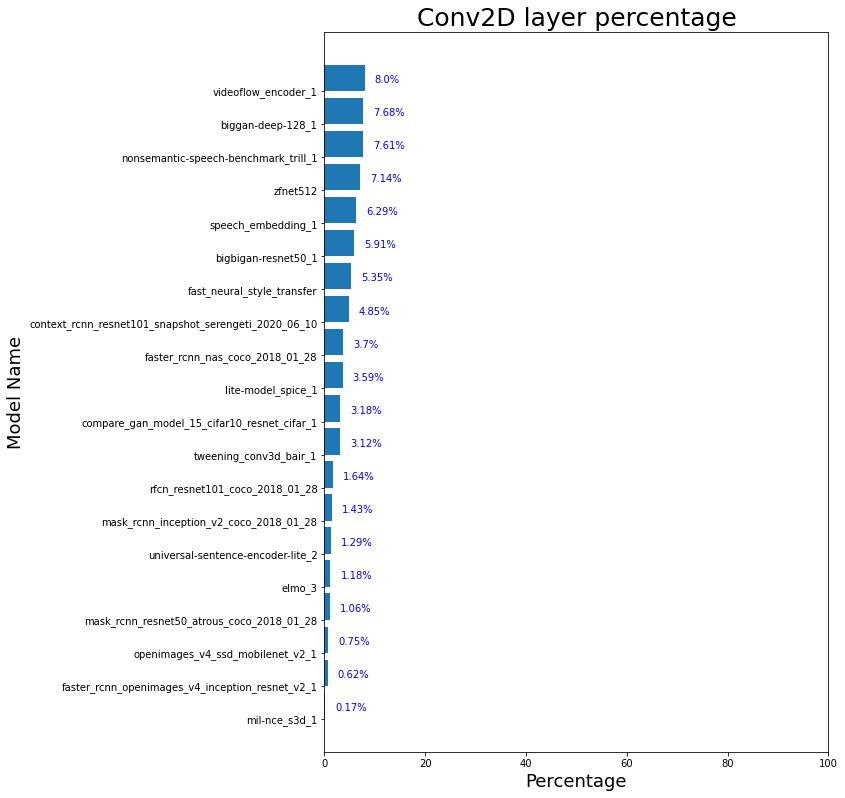

In [7]:
fig = plt.figure(figsize = (7,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Conv2D layer percentage", fontsize = 25)
ax.set_xlim([0, 100])
plt.barh(labels, values, align='edge')
ax.set_xlabel('Percentage', fontsize = 18)
ax.set_ylabel('Model Name', fontsize = 18)

for index, value in enumerate(values):
    ax.text(value + 2, index + .25, str(round(value,2)) + "%", color='blue')

plt.show()

In [8]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Placeholder", "Input_Placeholder")'
        ' AND model_type = "canonical" and source = "TFLite"'
        ' GROUP BY sub_category, operator_type'
        ' ORDER BY sub_category, count DESC;'
    )
    
category_op_dist = dict()
category_total_ops = dict()

categories = list()

for row in results:
    if row[0] not in categories:
        op_dist = dict()        
        categories.append(row[0])
    op_dist[row[1]] = row[2]
    category_op_dist[row[0]] = op_dist
    
    if row[0] not in category_total_ops:
        category_total_ops[row[0]] = 0

    category_total_ops[row[0]] += row[2]

sum 3134


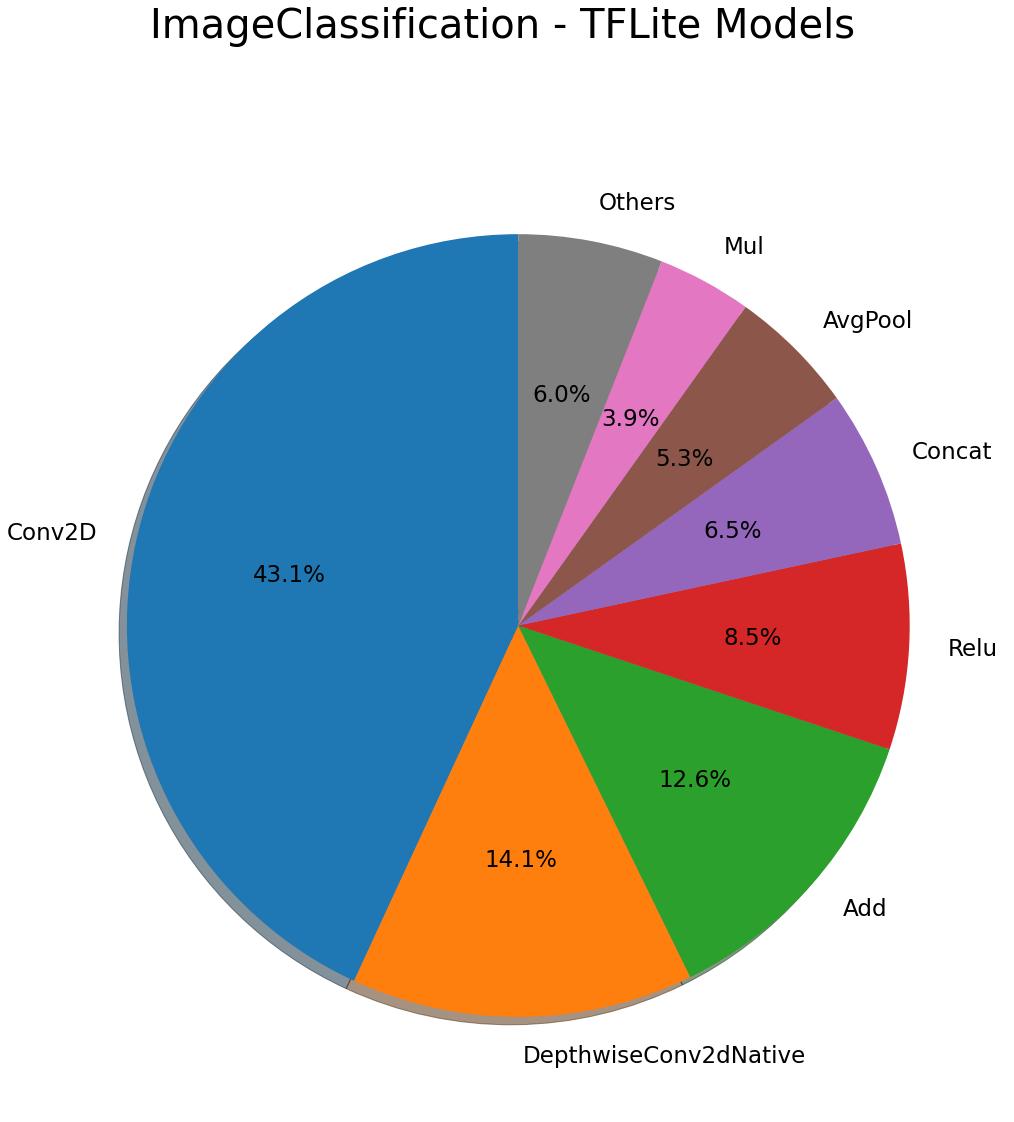

sum 772


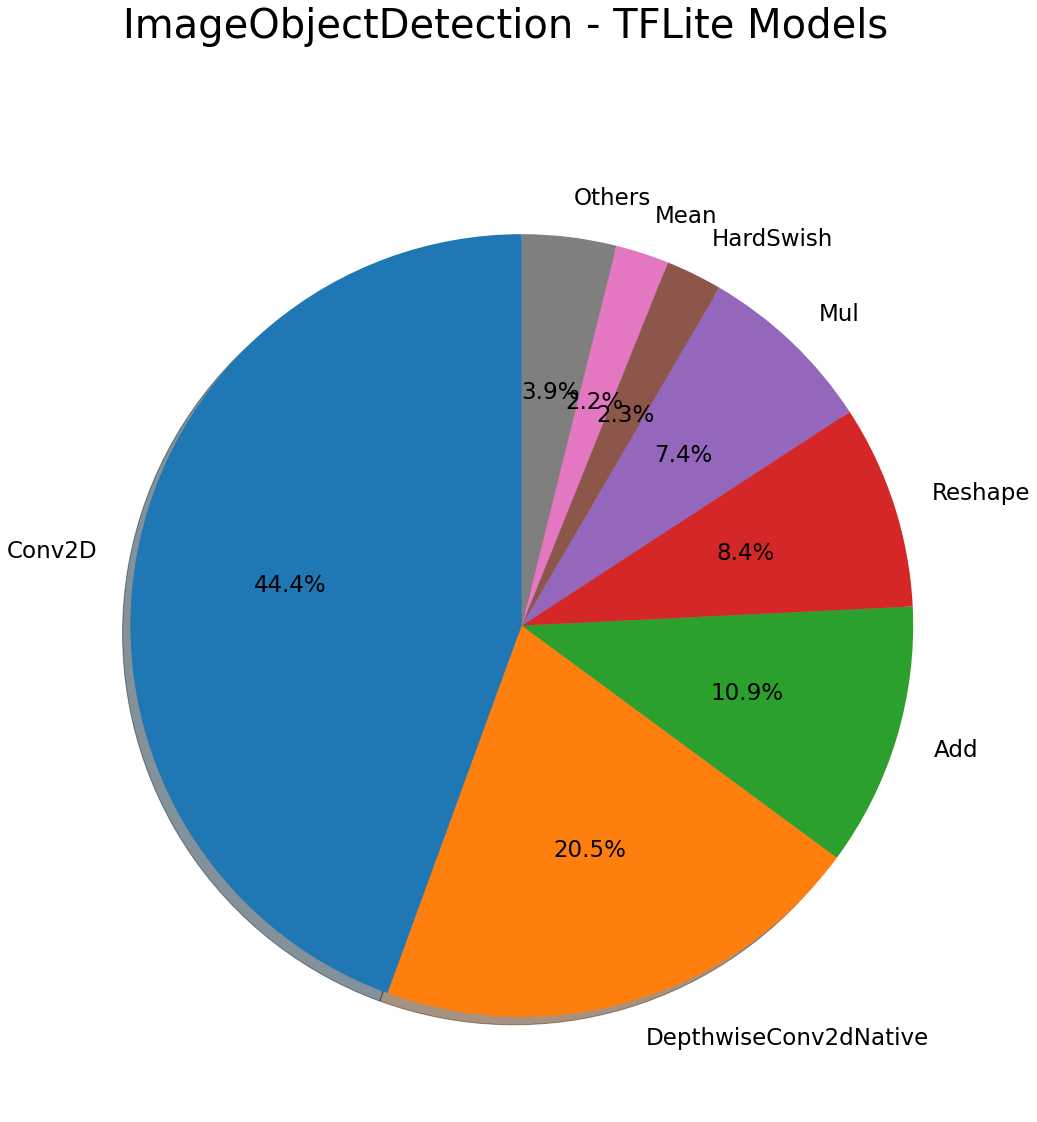

sum 993


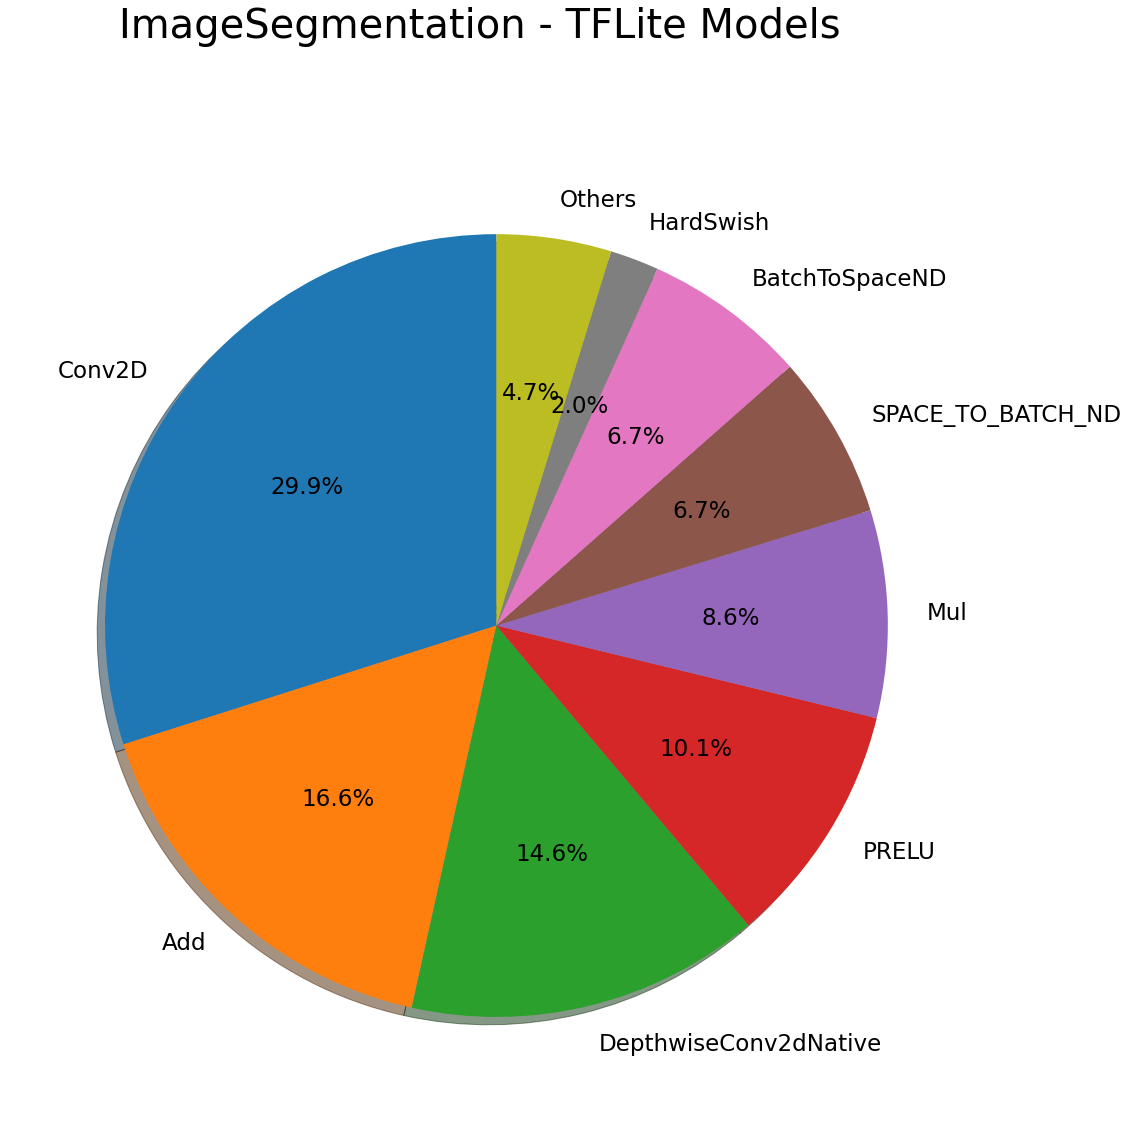

sum 5219


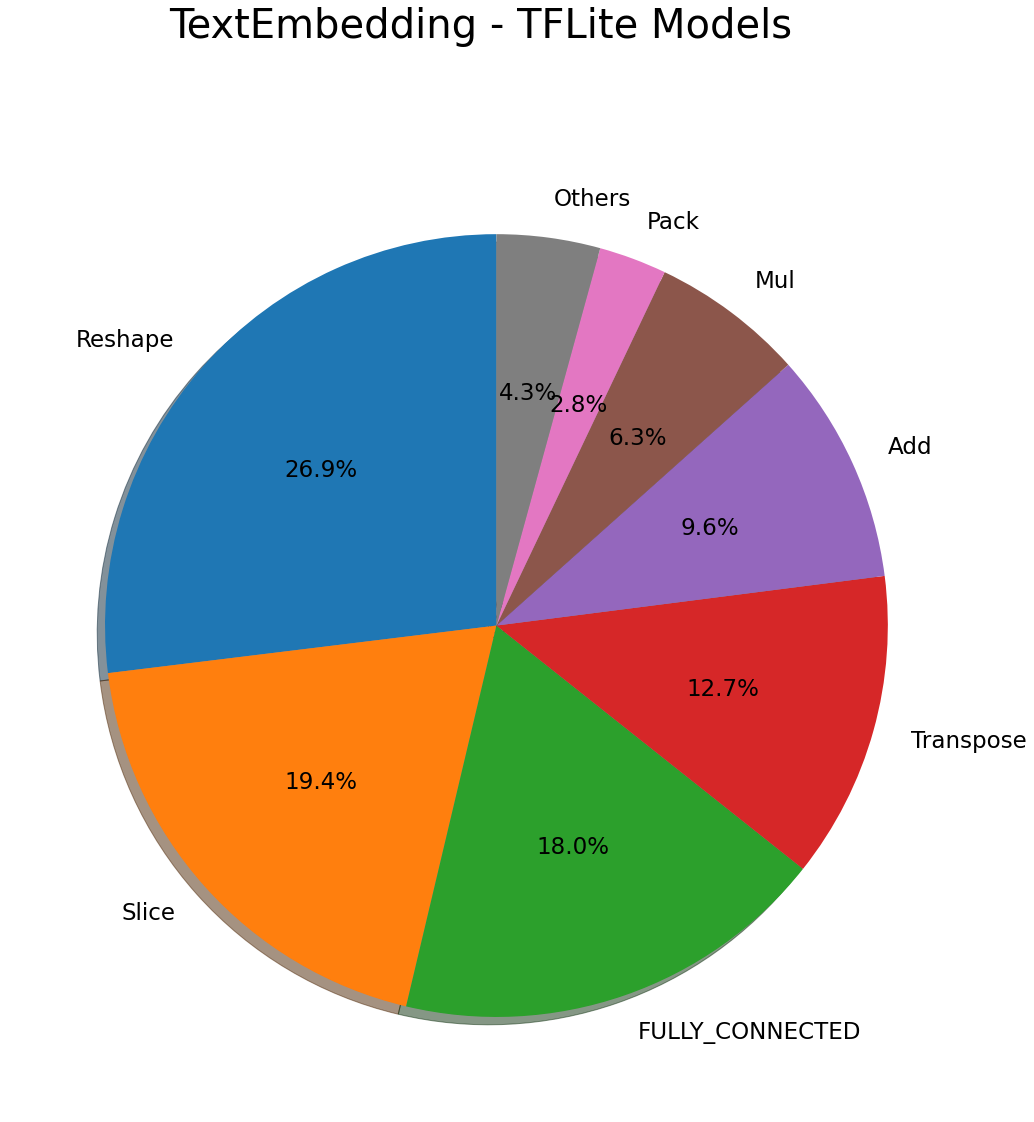

sum 3274


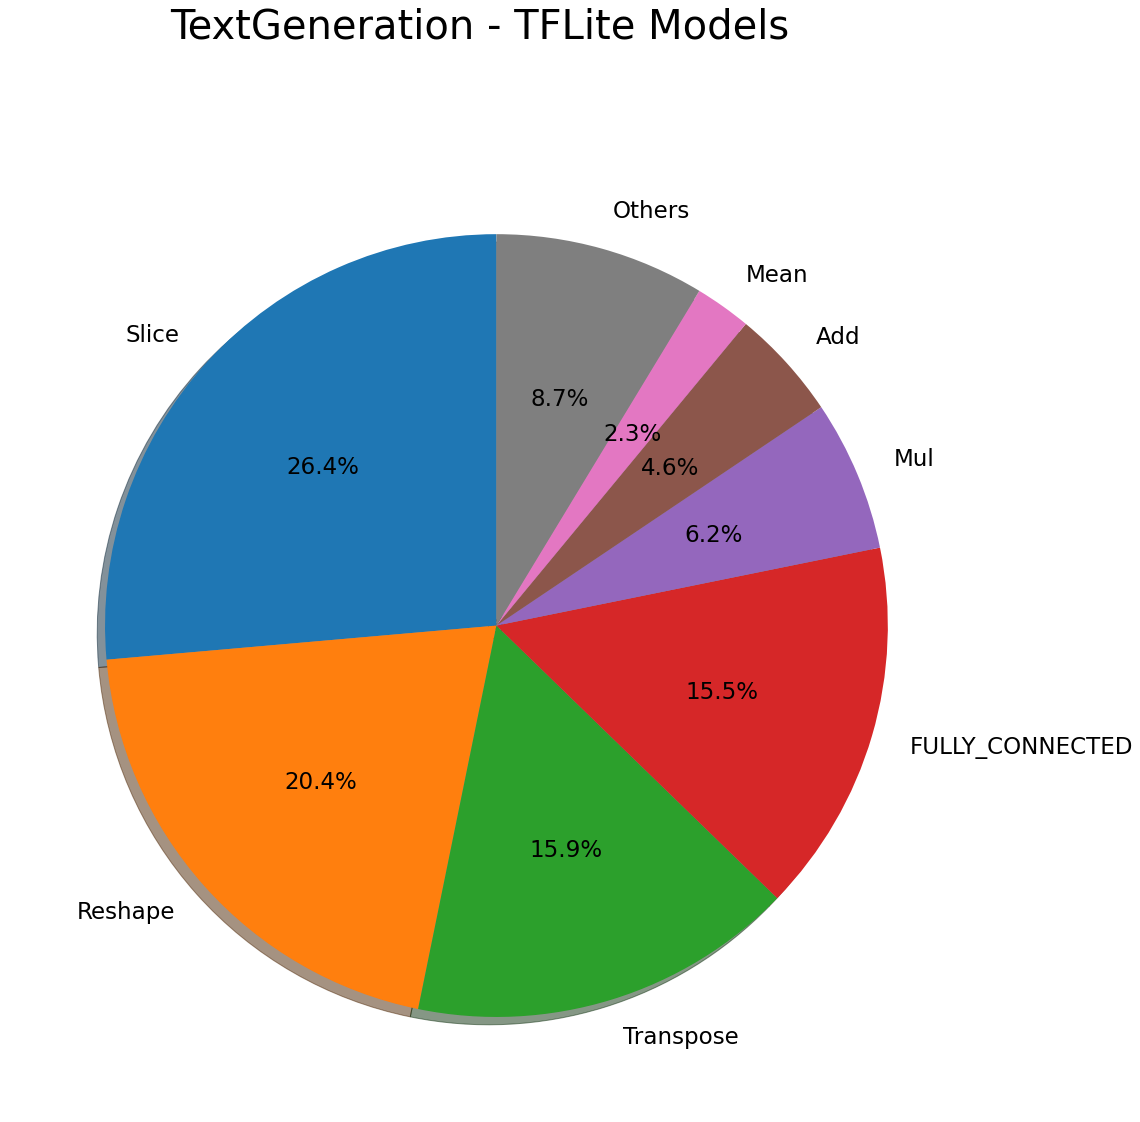

sum 2825


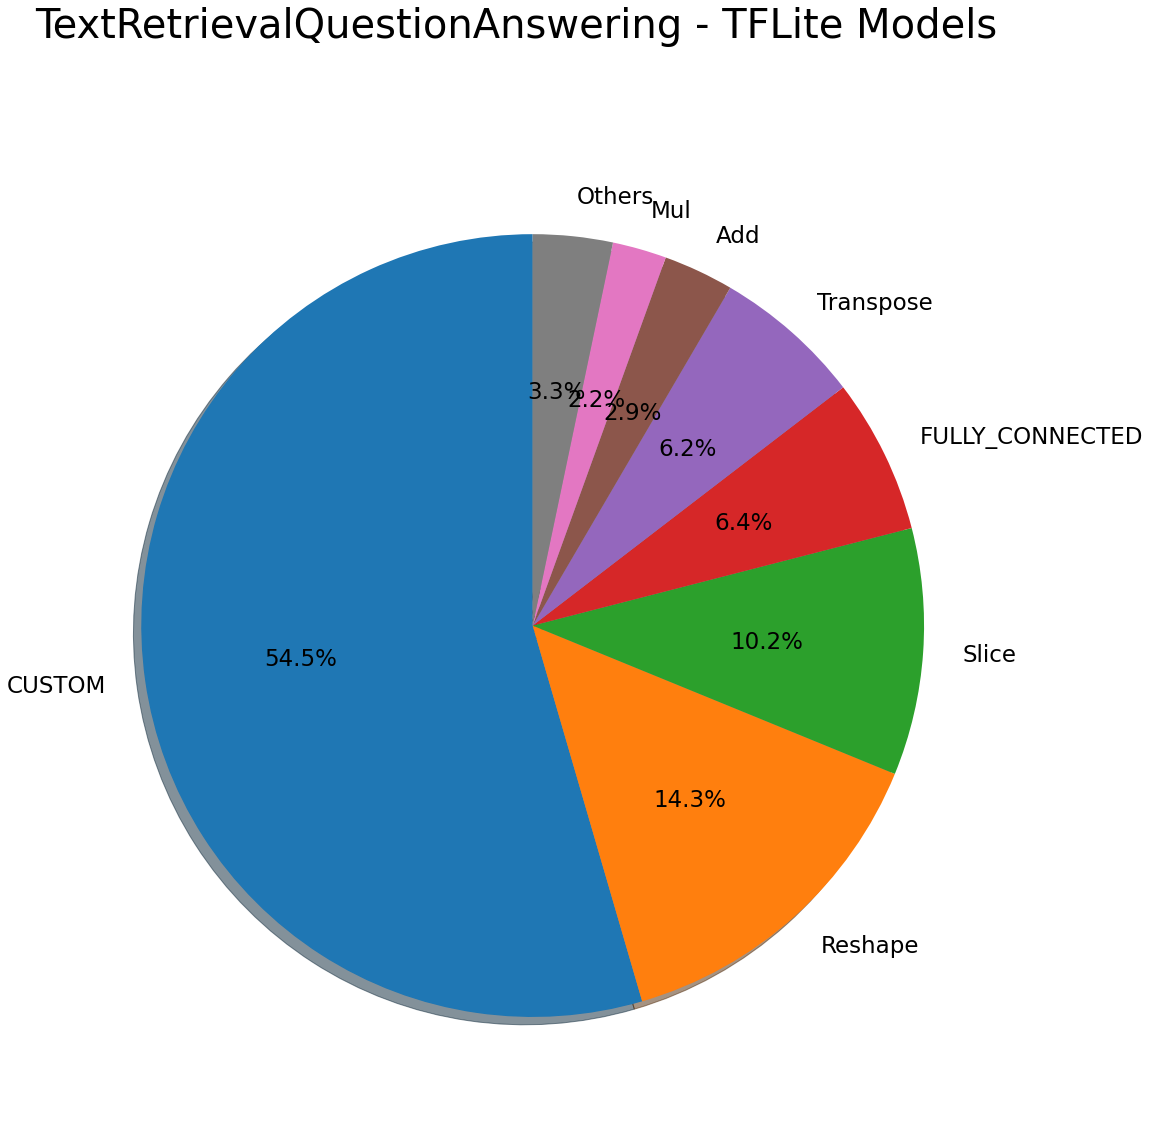

In [9]:
for category in categories:
    if(num_models[category] >= 3):
        labels = list(category_op_dist[category].keys())
        values = list(category_op_dist[category].values())

        sum_values = sum(values)
        print("sum" , sum_values)

        cumm_val = 0
        for index in reversed(range(len(labels))):
            if values[index] / sum_values > 0.02:
                break

            cumm_val += values[index]
            values.pop(index)
            labels.pop(index)


        if cumm_val != 0:
            labels.append("Others")
            values.append(cumm_val)

        fig, ax = plt.subplots(figsize = (18, 18))

        ax.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 23})
        fig.suptitle(category + " - TFLite Models", fontsize = '40')
        plt.show()

In [10]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT sub_category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Placeholder", "Input_Placeholder")'
        ' AND model_type = "canonical" and source = "TF"'
        ' GROUP BY sub_category, operator_type'
        ' ORDER BY sub_category, count DESC;'
    )
    
category_op_dist = dict()
category_total_ops = dict()

categories = list()

for row in results:
    if row[0] not in categories:
        op_dist = dict()        
        categories.append(row[0])
    op_dist[row[1]] = row[2]
    category_op_dist[row[0]] = op_dist
    
    if row[0] not in category_total_ops:
        category_total_ops[row[0]] = 0

    category_total_ops[row[0]] += row[2]

sum 10261


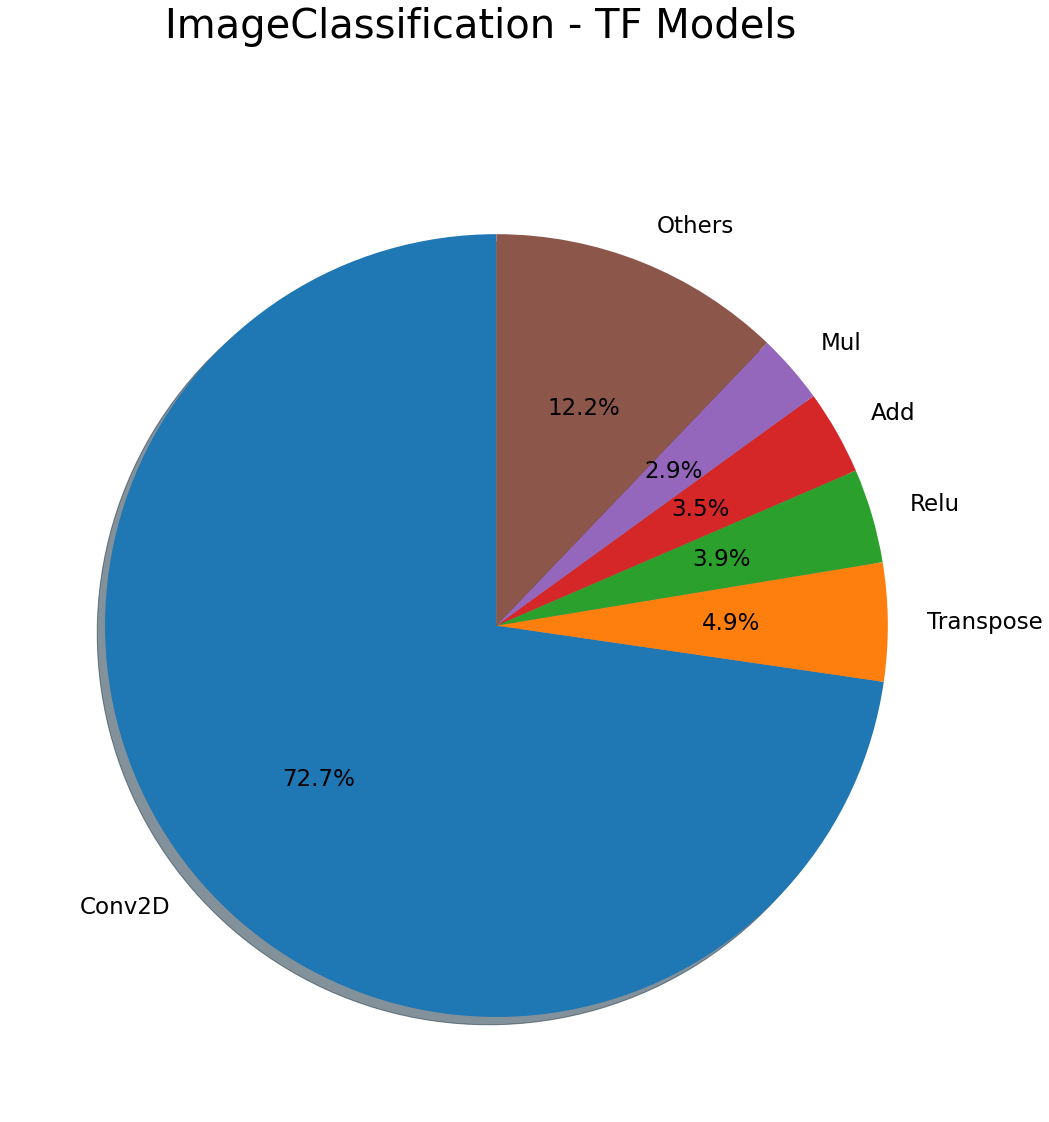

sum 8903


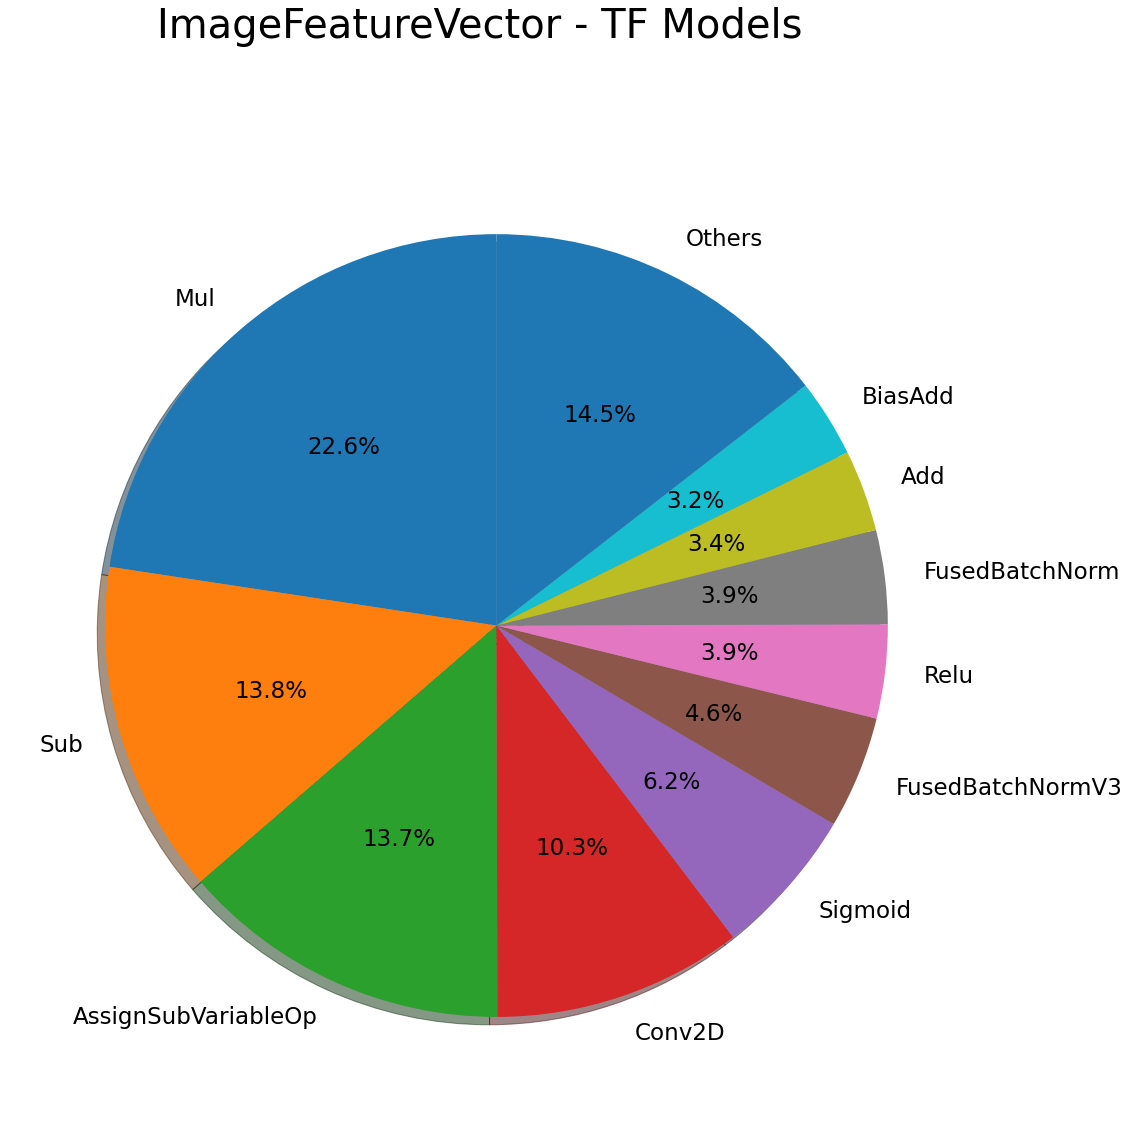

sum 5413


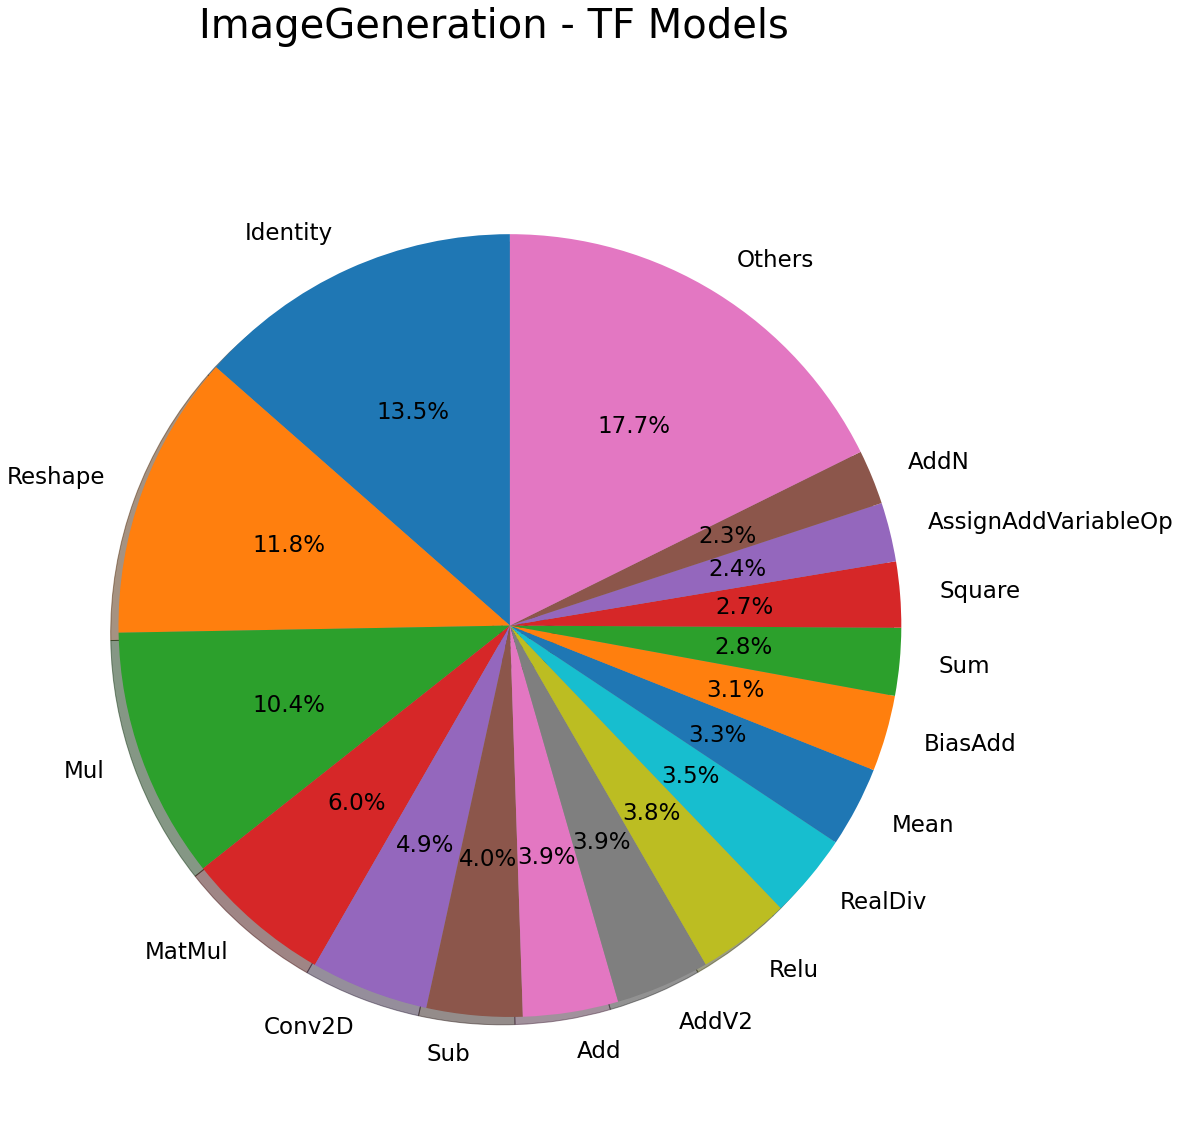

sum 78101


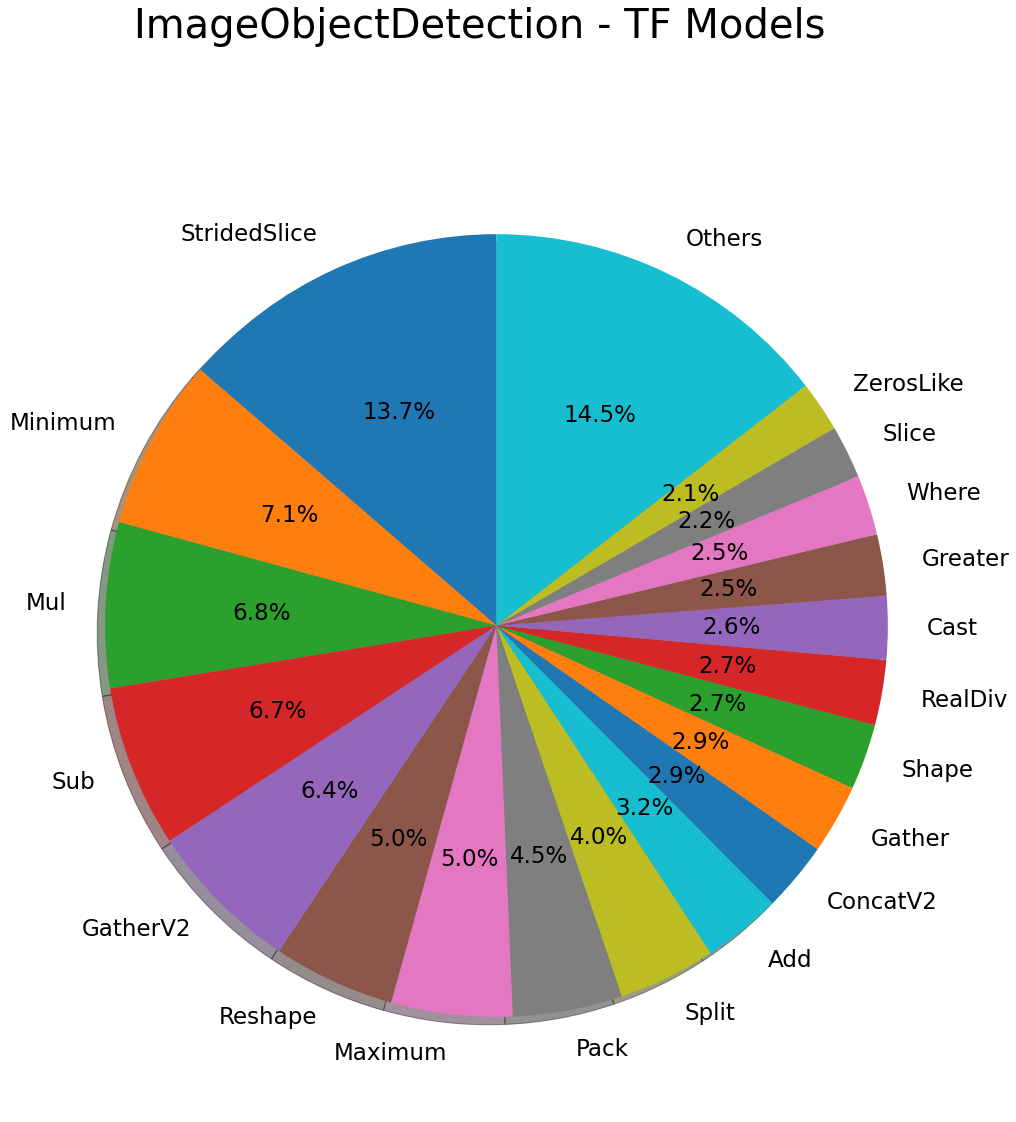

sum 1106


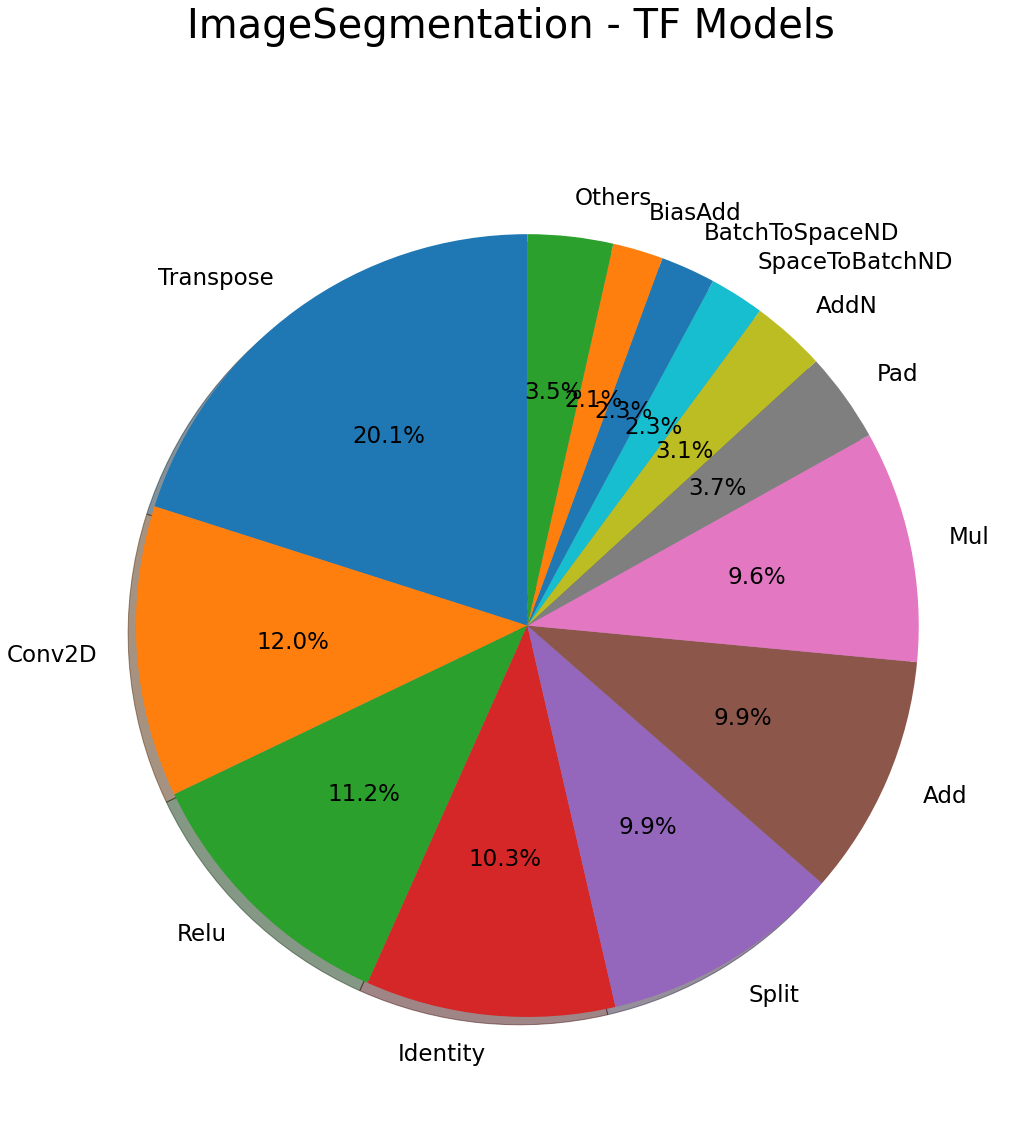

sum 12064


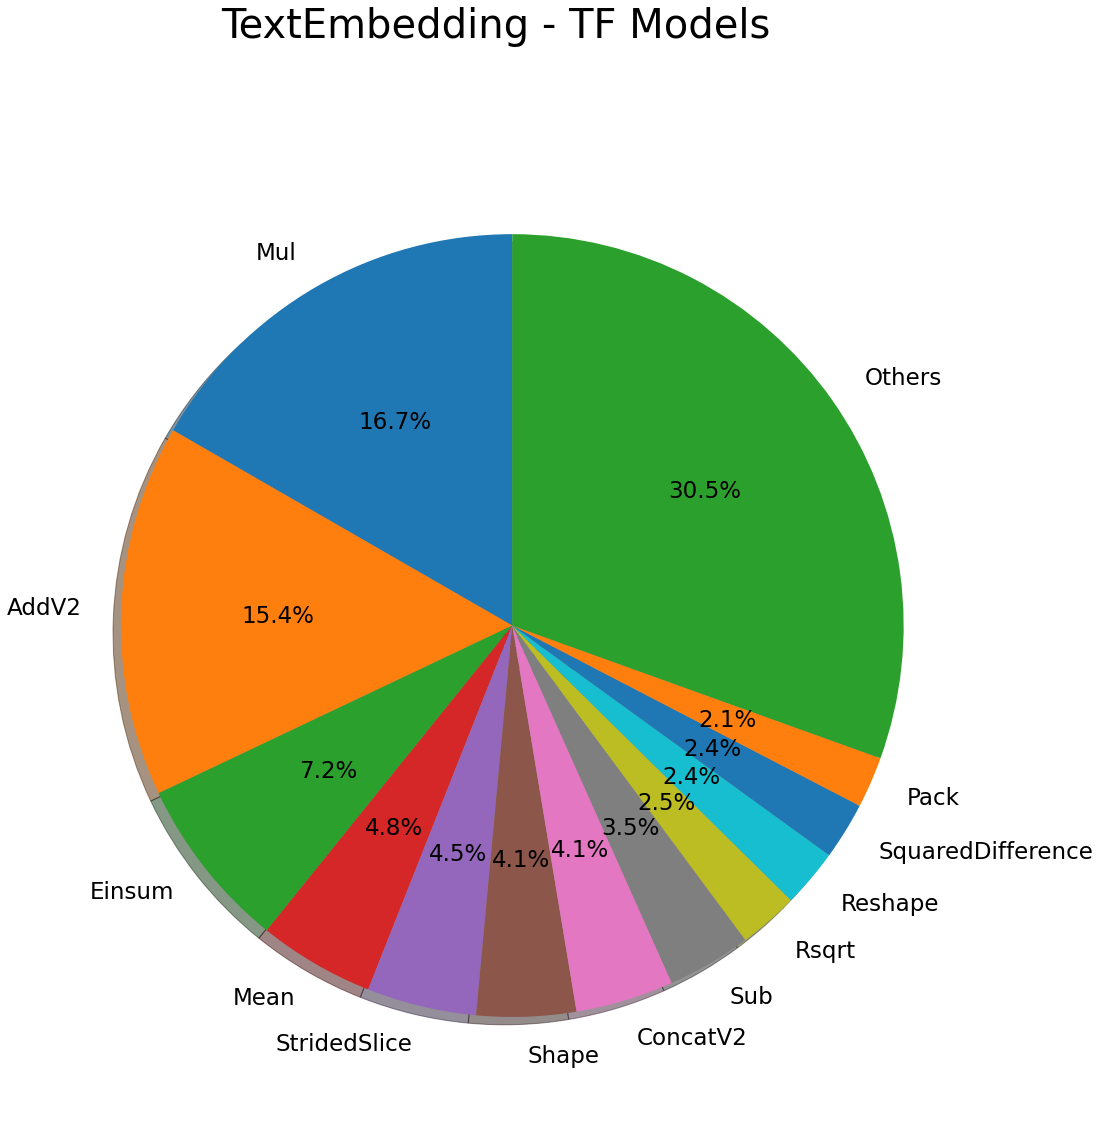

sum 3016


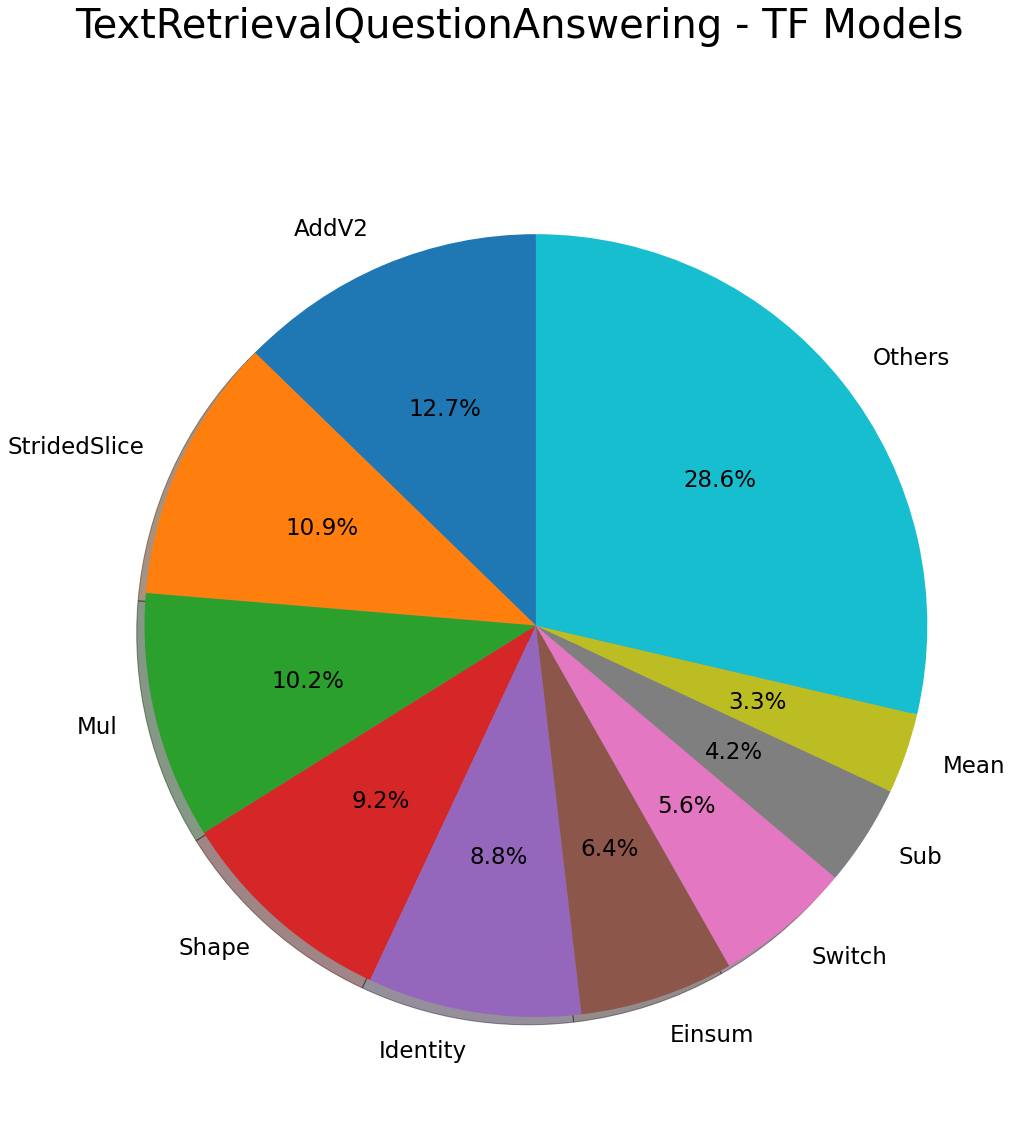

In [11]:
for category in categories:
    if(num_models[category] >= 3):
        labels = list(category_op_dist[category].keys())
        values = list(category_op_dist[category].values())

        sum_values = sum(values)
        print("sum" , sum_values)

        cumm_val = 0
        for index in reversed(range(len(labels))):
            if values[index] / sum_values > 0.02:
                break

            cumm_val += values[index]
            values.pop(index)
            labels.pop(index)


        if cumm_val != 0:
            labels.append("Others")
            values.append(cumm_val)

        fig, ax = plt.subplots(figsize = (18, 18))

        ax.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 23})
        fig.suptitle(category + " - TF Models", fontsize = '40')
        plt.show()

In [12]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, padding, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE operator_type NOT IN ("Output_Placeholder", "Input_Placeholder")'
        ' AND padding IS NOT NULL and model_type = "canonical"'
        ' GROUP BY operator_type, padding'
        ' ORDER BY operator_type, count DESC;'
    )

In [13]:
operation_padding = dict()

for row in results:
    if row[0] not in operation_padding:
        operation_padding[row[0]] = dict()
        operation_padding[row[0]]['SAME'] = 0
        operation_padding[row[0]]['VALID'] = 0

    operation_padding[row[0]][row[1]] = row[2]
    

labels = list(operation_padding.keys())
same_pad_values = list()
valid_pad_values = list()

for label in labels:
    same_num = operation_padding[label]['SAME']
    valid_num = operation_padding[label]['VALID']
    total = same_num + valid_num
    same_pad_values.append(round((same_num / total) *  100))
    valid_pad_values.append(round((valid_num / total) * 100))

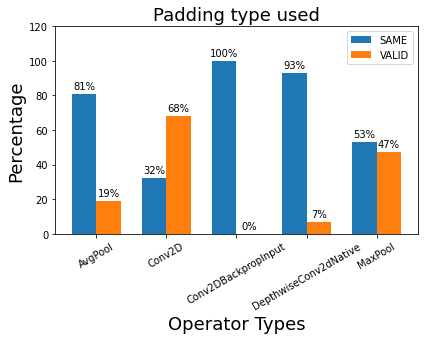

In [14]:
fig, ax = plt.subplots()

x = np.arange(len(labels))  # the label locations
width = 0.35
rects1 = ax.bar(x - width/2, same_pad_values, width, label='SAME')
rects2 = ax.bar(x + width/2, valid_pad_values, width, label='VALID')

ax.set_ylabel('Percentage', fontsize = 18)
ax.set_xlabel('Operator Types', fontsize = 18)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title("Padding type used", fontsize = 18)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height) + "%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.xticks(rotation=30)

ax.set_ylim([0, 120])

plt.show()

In [15]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT activation_function, COUNT(operator_type) as count'
        ' FROM Models JOIN Operators'
        ' ON Models.model_name = Operators.model_name'
        ' WHERE activation_function IS NOT NULL AND activation_function != "NONE"'
        ' AND model_type = "canonical"'
        ' GROUP BY activation_function'
        ' ORDER BY count DESC;'
    )

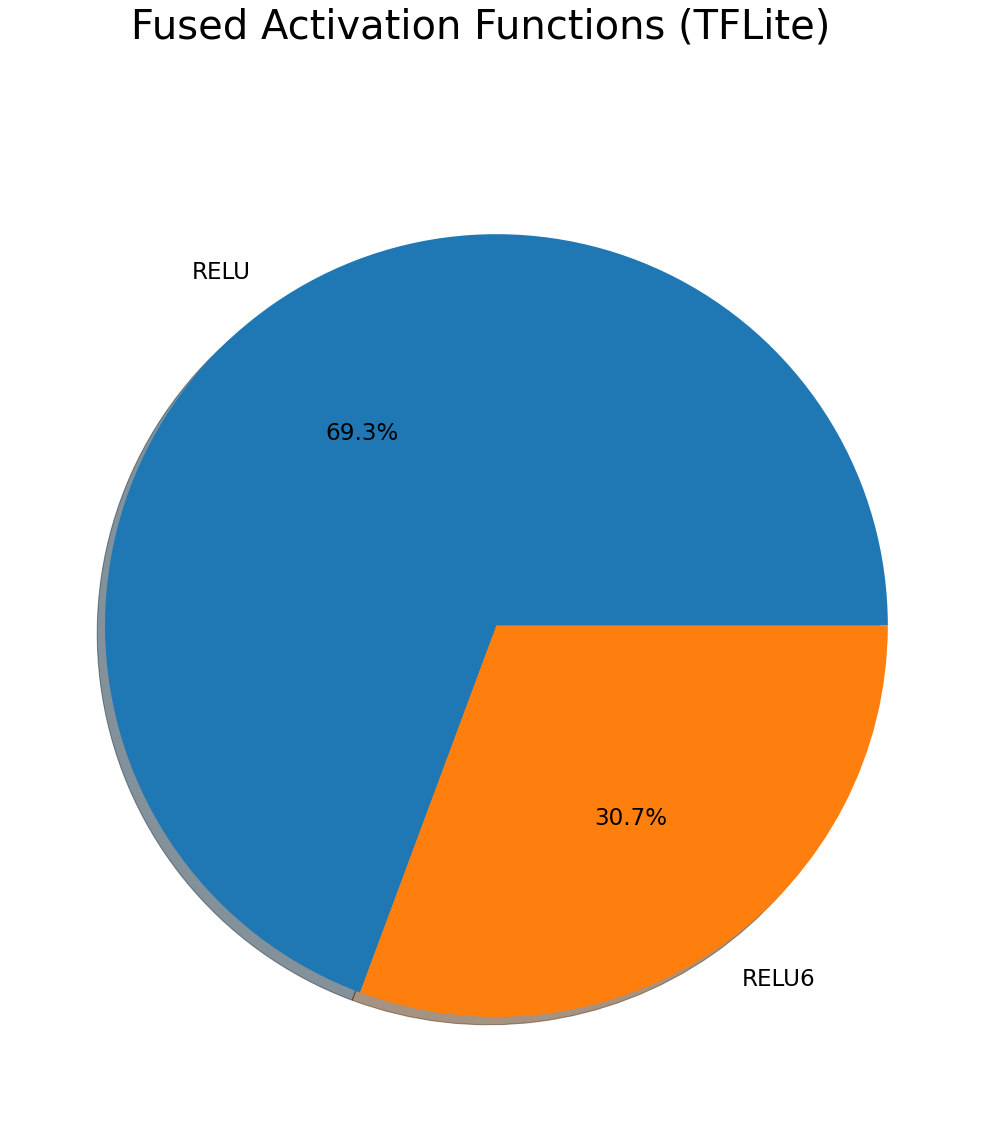

In [16]:
fused_activation_count = dict()
total_count = 0

for row in results:
    fused_activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(fused_activation_count.keys())
values = list(fused_activation_count.values())

fig, ax = plt.subplots(figsize = (18, 18))
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
fig.suptitle("Fused Activation Functions (TFLite)", fontsize = '40')
plt.show()

In [17]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT operator_type, COUNT(operator_id) as count'
        ' FROM Operators JOIN Models'
        ' ON Operators.model_name = Models.model_name'
        ' WHERE operator_type IN' 
        ' ("Relu", "Relu6", "Sigmoid", "Elu", "Selu", "Softplus", "Softsign", "Tanh", "Softmax")'
        ' AND model_type = "canonical"'
        ' GROUP BY operator_type'
        ' ORDER BY count DESC;'
    )

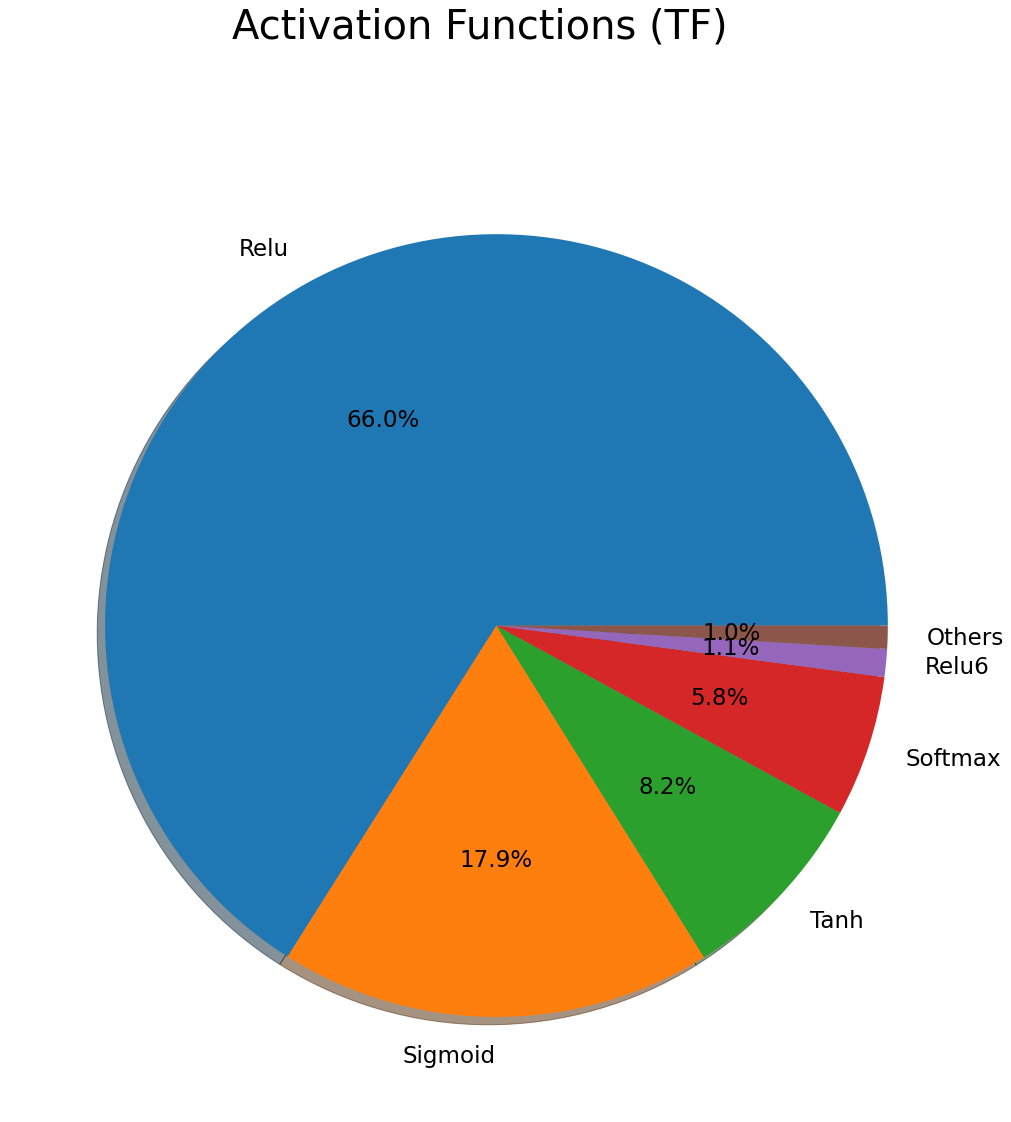

In [18]:
activation_count = dict()
total_count = 0

for row in results:
    activation_count[row[0]] = row[1]
    total_count += row[1]
    
labels = list(activation_count.keys())
values = list(activation_count.values())

others = 0

for index in reversed(range(len(values))):
    if values[index] / sum(values) <= 0.01 :
        others += values[index]
        values.pop(index)
        labels.pop(index)
        
values.append(others)
labels.append('Others')

fig, ax = plt.subplots(figsize = (18, 18))
ax.pie(values, labels = labels, autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 23})
fig.suptitle("Activation Functions (TF)", fontsize = '40')
plt.show()

In [19]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT category, operator_type, COUNT(operator_id) as count'
        ' FROM Models JOIN Operators ON Models.model_name = Operators.model_name'
        ' WHERE operator_type IN' 
        ' ("Relu", "Relu6", "Sigmoid", "Elu", "Selu", "Softplus", "Softsign", "Tanh", "Softmax")'
        ' and model_type = "canonical"'
        ' GROUP BY category, operator_type'
        ' ORDER BY count DESC;'
    )

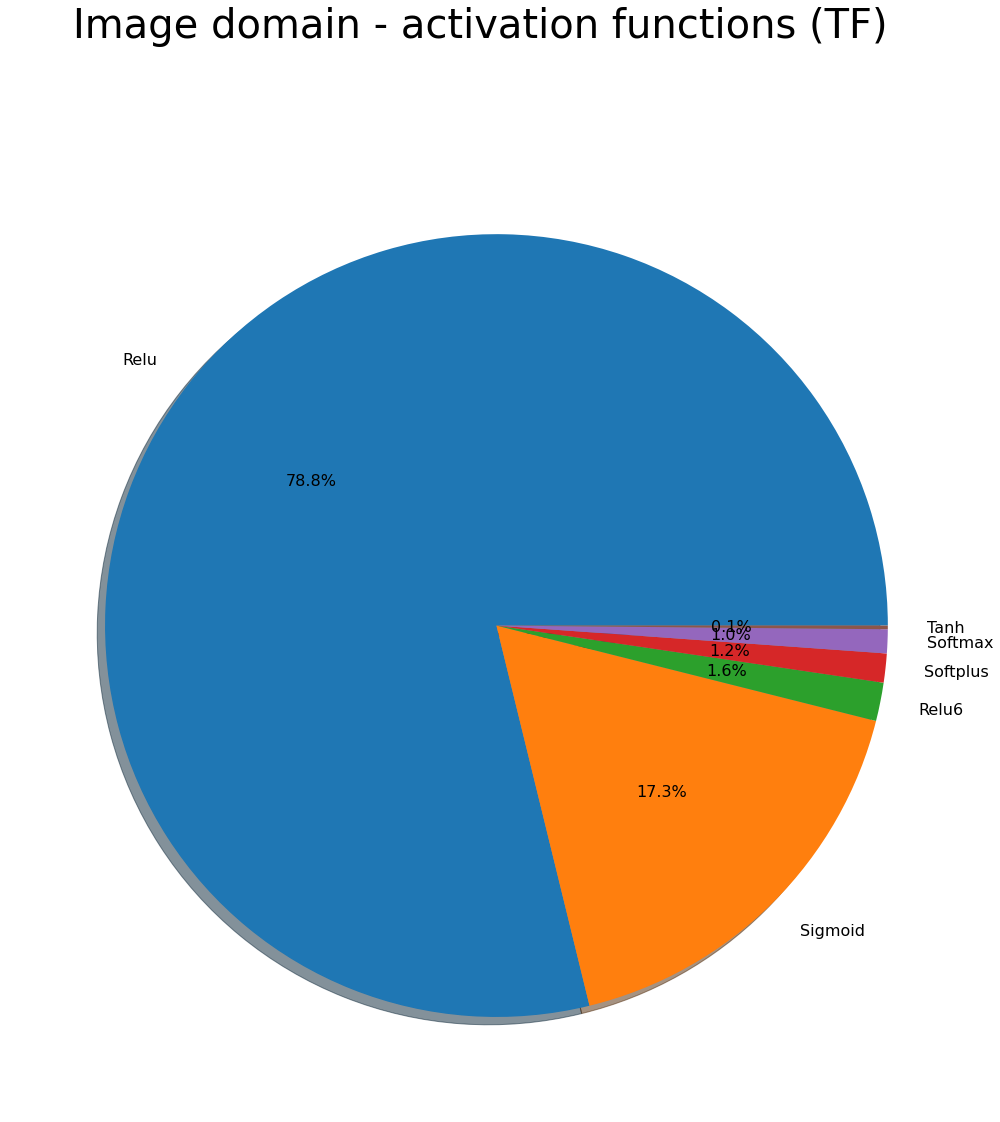

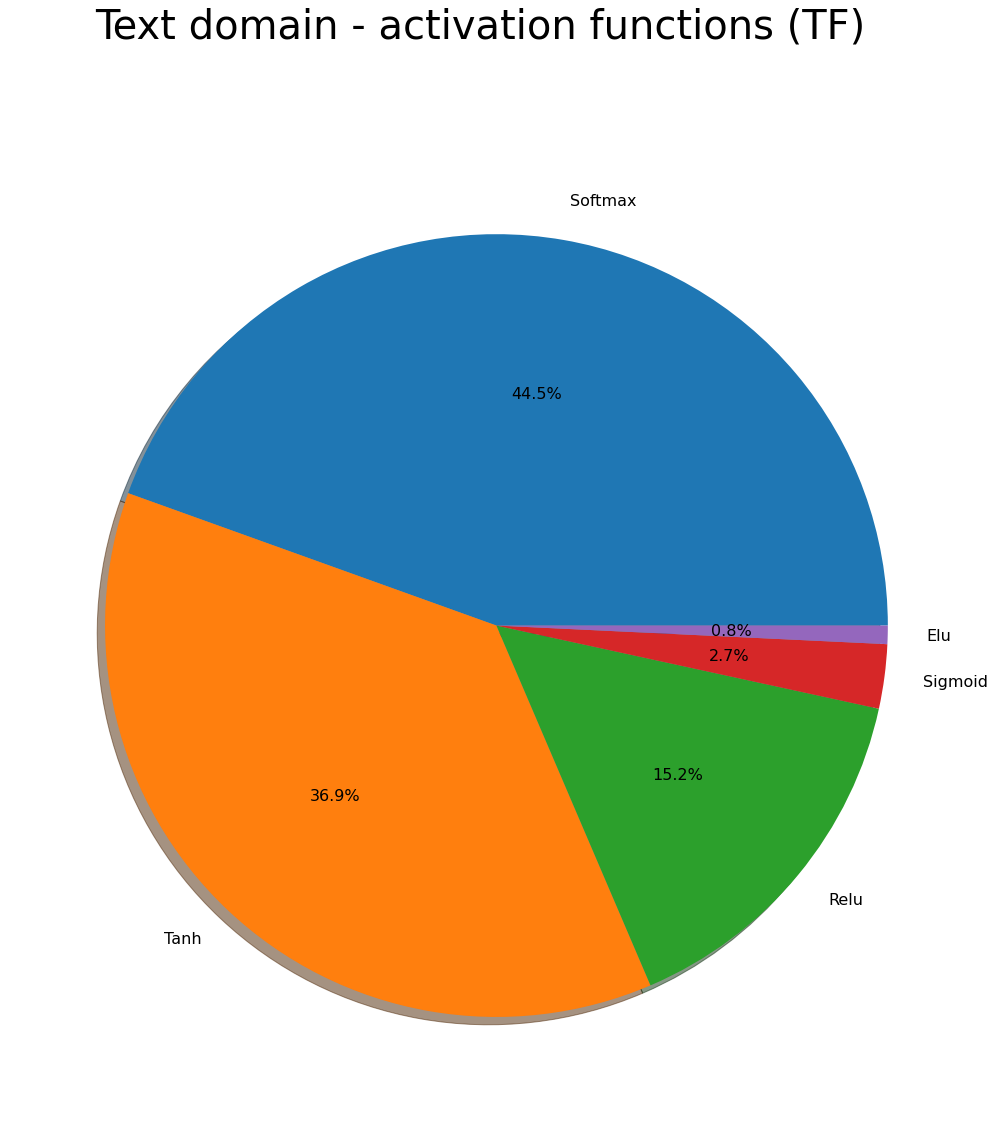

In [20]:
categories = list()
activation_data = dict()
activation_data.update({"Image" : dict()})
activation_data.update({"Text" : dict()})

for row in results:
    
    if "Image" in row[0] or row[0] == "ObjectDetection":
        if row[1] not in activation_data["Image"]:
            activation_data["Image"].update({row[1] : 0})
        activation_data["Image"][row[1]] += row[2]
    elif "Text" in row[0]:
        if row[1] not in activation_data["Text"]:
            activation_data["Text"].update({row[1] : 0})
        activation_data["Text"][row[1]] += row[2]

for key in activation_data.keys():
    
    labels = list(activation_data[key].keys())
    values = list(activation_data[key].values())
    
    fig, ax = plt.subplots(figsize = (18, 18))
    ax.pie(values, labels = labels,
           autopct='%1.1f%%', shadow=True, startangle=0, textprops={'fontsize': 16})
    fig.suptitle(key + " domain - activation functions (TF)", fontsize = '40')
    plt.show()

In [21]:
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        'SELECT model_name, embeddings FROM Models WHERE embeddings IS NOT NULL'
    )
    
embeddings_data = dict()
for row in results:
    embeddings_data[row[0]] = row[1]

In [22]:
labels = list(embeddings_data.keys())
embeddings = list(embeddings_data.values())

tsne_model = TSNE()
new_embeddings = tsne_model.fit_transform(embeddings)

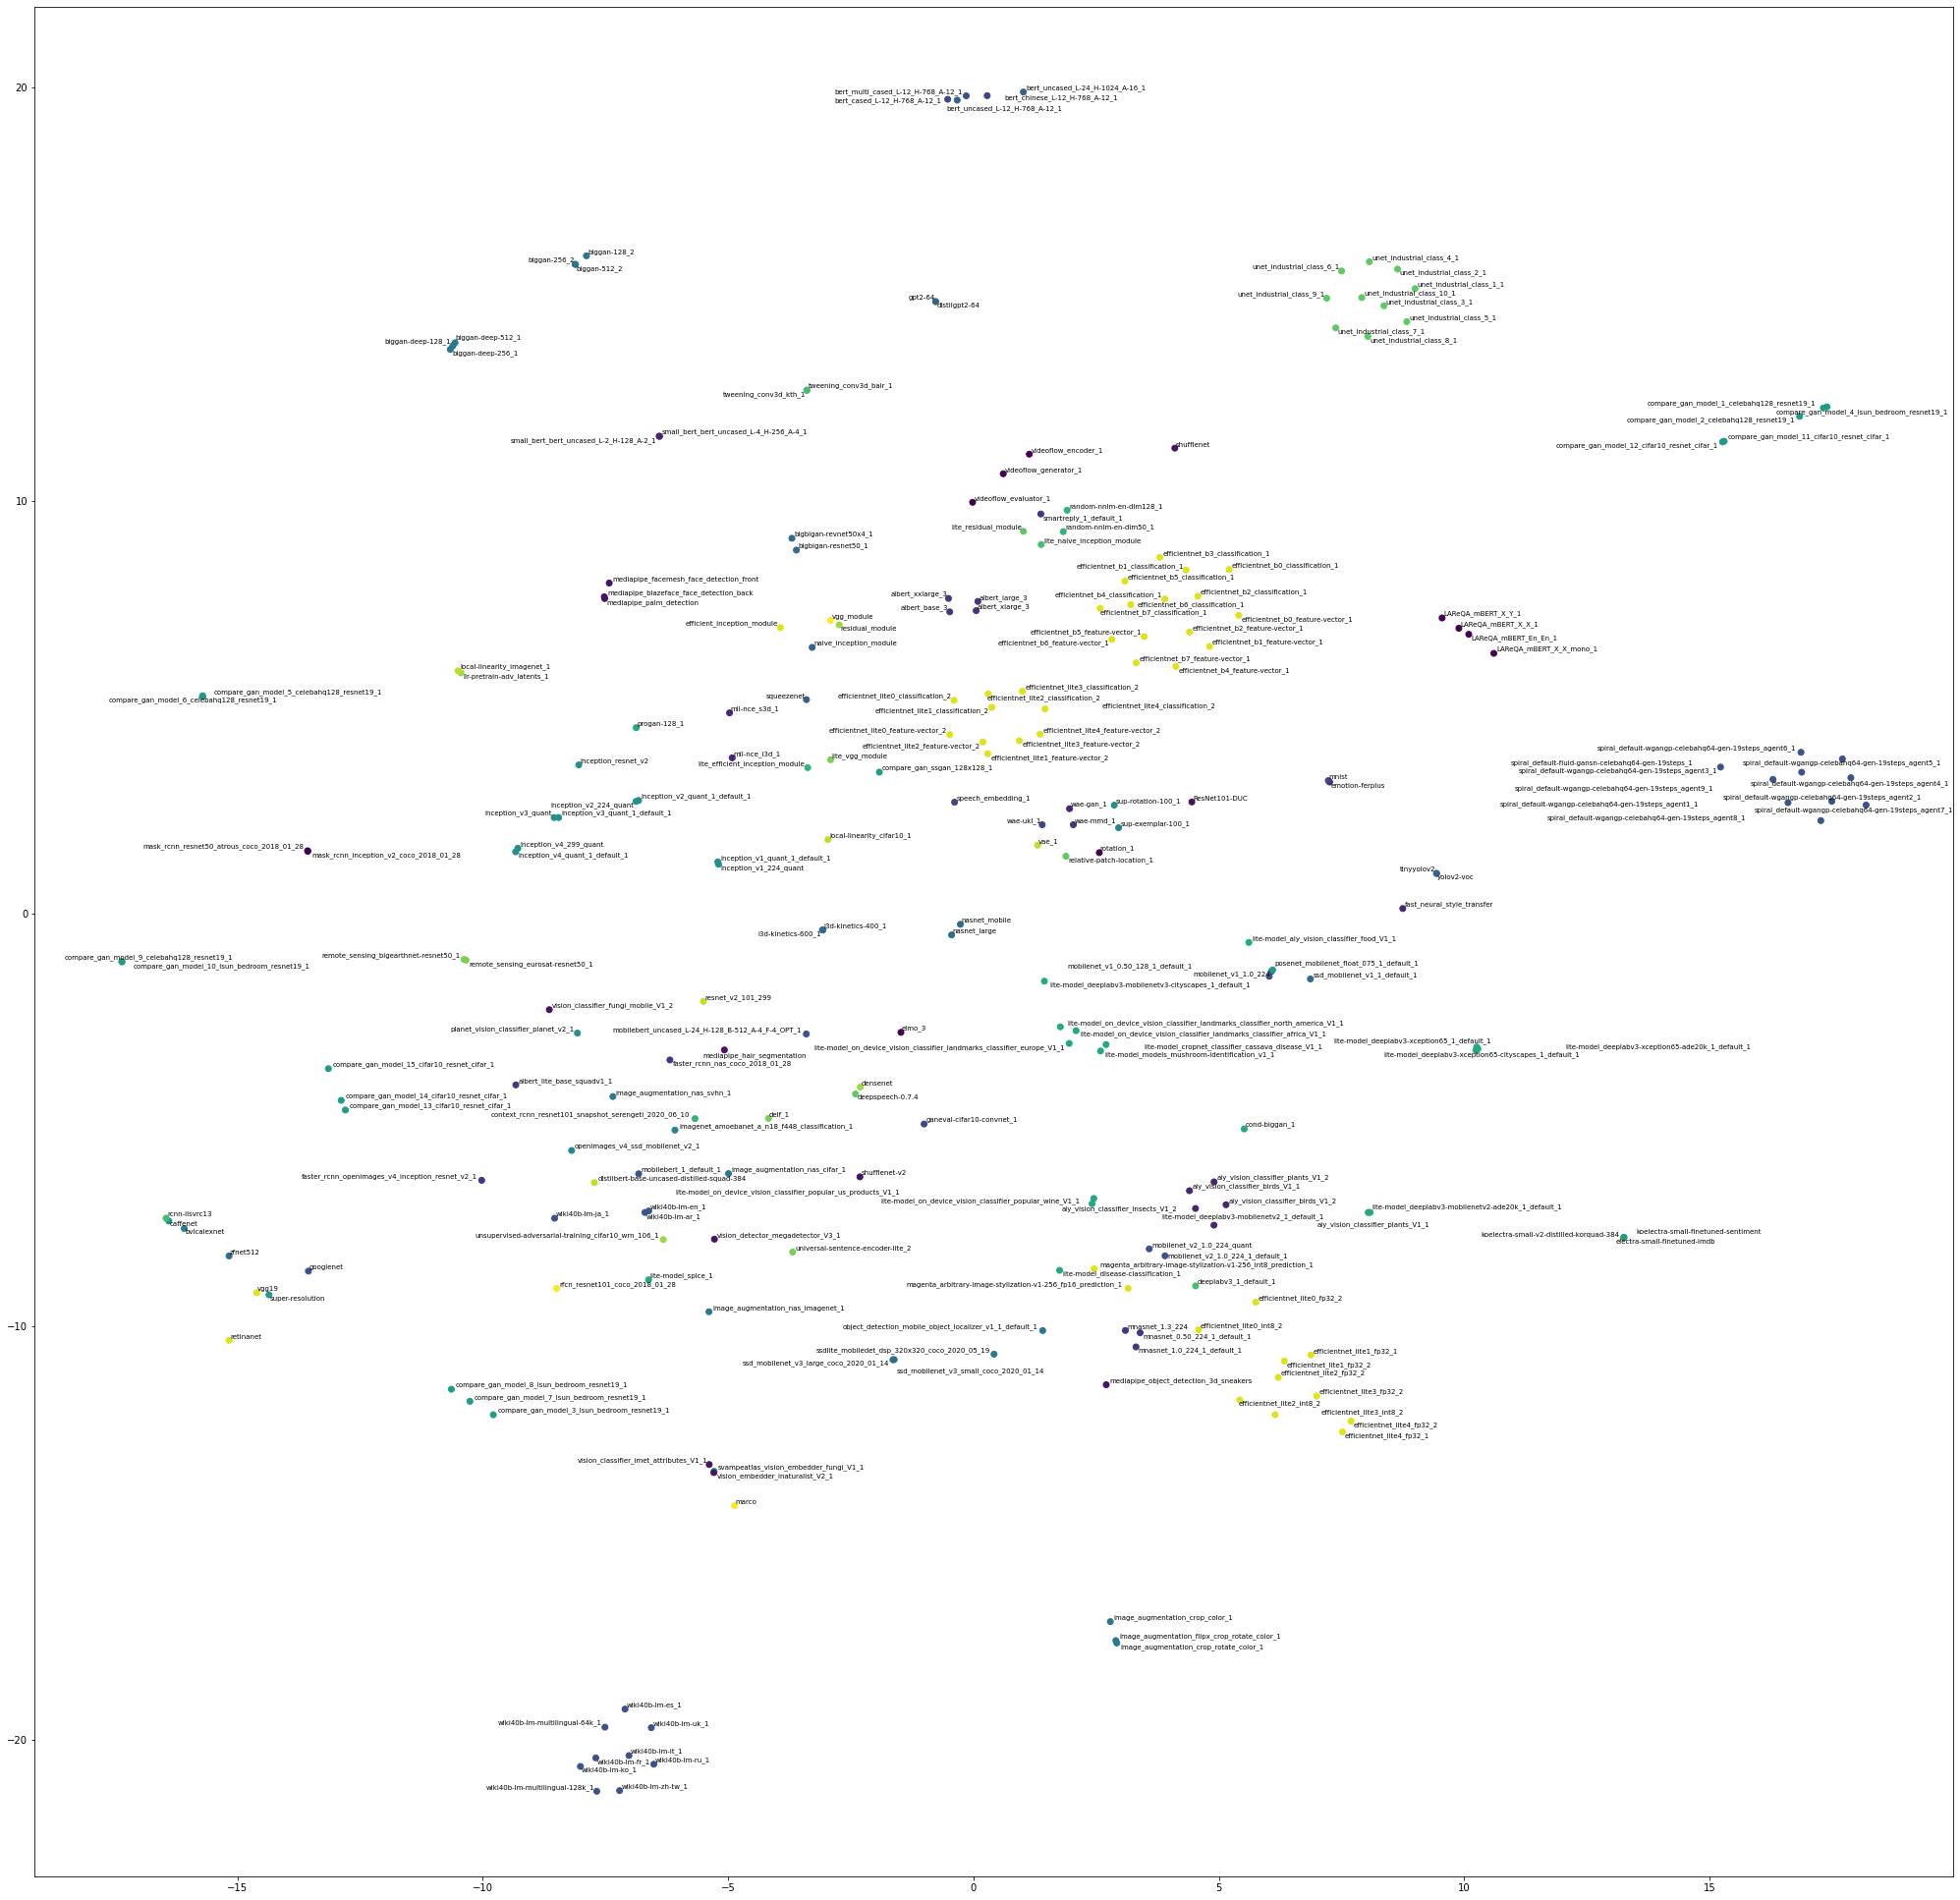

In [23]:
x = list()
y = list()

for embedding in new_embeddings:
    x.append(embedding[0])
    y.append(embedding[1])
    
colors = [(230, 25, 75), (60, 180, 75), (255, 225, 25), (0, 130, 200), (245, 130, 48),
          (145, 30, 180), (70, 240, 240), (240, 50, 230), (210, 245, 60), (250, 190, 212),
          (0, 128, 128), (220, 190, 255), (170, 110, 40), (255, 250, 200), (128, 0, 0),
          (170, 255, 195), (128, 128, 0), (255, 215, 180), (0, 0, 128), (128, 128, 128),
          (0, 0, 0)]

distinct_model_names = set()

model_to_color = dict()
index = 0

colormap = list()

for label in labels:
    if label[:6] not in distinct_model_names:
        distinct_model_names.add(label[:6])
        model_to_color[label[:6]] = index
        index += 1
        index %= len(colors)
        
    colormap.append(model_to_color[label[:6]])
    
fig, ax = plt.subplots(figsize = (35, 35))
plt.scatter(x, y, c = colormap)

num_labels = range(len(labels))

texts = [plt.text(x[i], y[i], labels[i], fontsize = 7) for i in range(len(x))]
adjust_text(texts)
    
plt.show()